In [1]:
import os
import tomopy
import numpy as np
from imars3d.backend.diagnostics.tilt import calculate_tilt, apply_tilt_correction, find_180_deg_pairs_idx
import matplotlib.pyplot as plt
import sys
root_folder = os.path.dirname(os.getcwd())
sys.path.append(root_folder)
import utilities as rocku
import dxchange
import algotom.io.loadersaver as losa
import algotom.prep.correction as corr
import algotom.io.converter as conv
import algotom.prep.calculation as calc
import algotom.rec.reconstruction as rec
import bm3d_streak_removal as bm3d
import h5py as h5f
from tqdm import tqdm
import timeit
import multiprocessing as mp
import svmbir
import ast
# %matplotlib notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
ncore = mp.cpu_count()
ncore

64

# Workflow starts here!

In [2]:
###################### need to change start
ipts="33116"
###################### need to change end

In [3]:
# hdf5_loc = "/netdisk/y9z/IPTS-"+ipts+"/hdf5/"
hdf5_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/hdf5/"
os.listdir(hdf5_loc)

['2024_09_14_Ni_high_res_top2_924proj_gridrec.h5']

In [4]:
###################### need to change start
sample_name = "2024_09_14_Ni_high_res_top2_924proj_gridrec"
hdf5 = hdf5_loc + sample_name + ".h5"
###################### need to change end

# Load hdf5 file

In [5]:
losa.get_hdf_tree(hdf5)

 tomo
    │
    ├── info
    │   │
    │   ├── ang_deg (924,)
    │   ├── ang_rad (924,)
    │   ├── fname (924,)
    │   ├── proj000_idx (1,)
    │   └── proj180_idx (1,)
    ├── proj
    │   │
    │   ├── proj_mlog (924, 6299, 2200)
    │   ├── proj_mlog_roi (924, 1700, 2199)
    │   ├── proj_mlog_to_recon (924, 1700, 2199)
    │   └── proj_norm (924, 6299, 2200)
    ├── raw_ref
    │   │
    │   ├── dc_max (6300, 6100)
    │   ├── fluc_corr_roi_min (5000, 200)
    │   ├── ob_min (6300, 6100)
    │   ├── proj_crop_roi_min (6299, 2200)
    │   └── proj_min (6300, 6100)
    ├── recon
    │   │
    │   ├── history (1,)
    │   ├── recon_unit (1,)
    │   └── recon_volume (1700, 1470, 1220)
    └── sino
        │
        ├── sino_mlog (6299, 924, 2200)
        ├── sino_mlog_roi (1700, 924, 2199)
        └── sino_mlog_to_recon (1700, 924, 2199)


deque([' tomo',
       '    │',
       '    ├── info',
       '    │   │',
       '    │   ├── ang_deg (924,)',
       '    │   ├── ang_rad (924,)',
       '    │   ├── fname (924,)',
       '    │   ├── proj000_idx (1,)',
       '    │   └── proj180_idx (1,)',
       '    ├── proj',
       '    │   │',
       '    │   ├── proj_mlog (924, 6299, 2200)',
       '    │   ├── proj_mlog_roi (924, 1700, 2199)',
       '    │   ├── proj_mlog_to_recon (924, 1700, 2199)',
       '    │   └── proj_norm (924, 6299, 2200)',
       '    ├── raw_ref',
       '    │   │',
       '    │   ├── dc_max (6300, 6100)',
       '    │   ├── fluc_corr_roi_min (5000, 200)',
       '    │   ├── ob_min (6300, 6100)',
       '    │   ├── proj_crop_roi_min (6299, 2200)',
       '    │   └── proj_min (6300, 6100)',
       '    ├── recon',
       '    │   │',
       '    │   ├── history (1,)',
       '    │   ├── recon_unit (1,)',
       '    │   └── recon_volume (1700, 1470, 1220)',
       '    └── sino',
       ' 

In [17]:
history_dict_str = losa.load_hdf(hdf5, key_path='tomo/recon/history')[0]
history_dict = ast.literal_eval(history_dict_str.decode("utf-8"))
proj_mlog = losa.load_hdf(hdf5, key_path='tomo/proj/proj_mlog_to_recon')
# sino_mlog = losa.load_hdf(hdf5, key_path='tomo/sino/sino_mlog')
sino_mlog = losa.load_hdf(hdf5, key_path='tomo/sino/sino_mlog_to_recon')
ang_rad = losa.load_hdf(hdf5, key_path='tomo/info/ang_rad')
proj000_idx = losa.load_hdf(hdf5, key_path='tomo/info/proj000_idx')[0]
proj180_idx = losa.load_hdf(hdf5, key_path='tomo/info/proj180_idx')[0]
proj360_idx = losa.load_hdf(hdf5, key_path='tomo/info/proj360_idx')[0]
rot_center_used = history_dict['rot_center']
rot_center_180 = history_dict['rot_center_180']
rot_center_360 = history_dict['rot_center_360']
# recon_hdf5 = losa.load_hdf(hdf5, key_path='tomo/recon/recon_volume')
gamma_diff = 20
# sino_mlog_to_recon = np.moveaxis(proj_mlog_to_recon, 1, 0)
if history_dict['recon_crop']:
    recon_crop = True
    recon_crop_left = history_dict['recon_crop_roi']['left']
    recon_crop_right = history_dict['recon_crop_roi']['right']
    recon_crop_top = history_dict['recon_crop_roi']['top']
    recon_crop_bottom = history_dict['recon_crop_roi']['bottom']
else:
    recon_crop = False
    recon_crop_left = None
    recon_crop_right = None
    recon_crop_top = None
    recon_crop_bottom = None
history_dict

{'crop': True,
 'crop_roi_dict': {'left': 2000, 'right': 4200, 'top': 0, 'bottom': -1},
 'gamma_filter': True,
 'gamma_diff': 20,
 'normalization': True,
 'pixel_bin_size': 1,
 'beam_fluc_corr': True,
 'beam_fluc_corr_roi_dict': {'left': 0,
  'right': 200,
  'top': 500,
  'bottom': 5500},
 'minus_log': True,
 'tilt_corr_use_mlog': True,
 'tilt_corr_use_pair': 0,
 'tilt_corr_use': 'neutompy',
 'rot_center_180': 1098.5,
 'rot_center_360': 1100.0,
 'rot_center': 1100.0,
 'tilt_corr': 'neutompy',
 'ring_rmv_roi': True,
 'ring_rmv_roi_dict': {'left': 0, 'right': -1, 'top': 1250, 'bottom': 2950},
 'ring_removal': 'bm3dgpu',
 'pixel_size_um': 7.8,
 'recon_unit': 'cm-1',
 'start_ang_idx': 0,
 'end_ang_idx': 923,
 'recon_algo': 'gridrec',
 'recon_crop': True,
 'recon_crop_roi': {'left': 580, 'right': 1800, 'top': 450, 'bottom': 1920}}

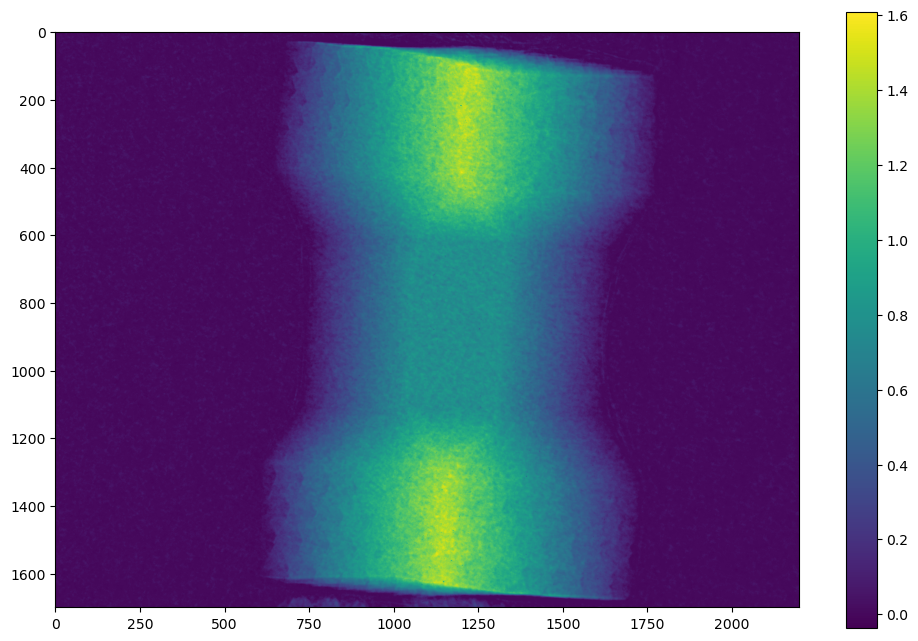

In [13]:
###################### need to change start
idx = 0
###################### need to change end
plt.imshow(proj_mlog[idx])
plt.colorbar()
plt.show()

# Reconstruction

In [16]:
# pix_um = 15.97 * pixel_bin_size # um
pix_um = 7.8 # um
# pix_um = 42 # um

# recon_algo = 'gridrec'
recon_algo = 'SIRT_CUDA'
# recon_algo = 'svmbir'

full_360 = True
# full_360 = False
##################################
slice_by_slice = False
if full_360:
    start_ang_idx = proj000_idx
    end_ang_idx = proj360_idx
    rot_center = rot_center_360
else:
    start_ang_idx = proj000_idx
    end_ang_idx = proj180_idx
    rot_center = rot_center_180
t0 = timeit.default_timer()
####################### tomopy algorithms (gridrec and fbp are faster than algotom) ##########################
if recon_algo in ['art', 'bart', 'fbp', 'gridrec',
                  'mlem', 'osem', 'ospml_hybrid', 'ospml_quad',
                  'pml_hybrid', 'pml_quad', 'sirt', 'tv', 'grad', 'tikh']:
    recon = tomopy.recon(proj_mlog_to_recon[start_ang_idx:end_ang_idx,:,:], ang_rad[start_ang_idx:end_ang_idx], center=rot_center,
                         algorithm=recon_algo,
                         ncore=ncore, 
#                          nchunk=nchunk
                        )
################################################ algotom algorithms ##########################################
    #### ASTRA
if recon_algo in ['FBP', 'SIRT', 'SART', 'ART', 'CGLS', 'FBP_CUDA', 'SIRT_CUDA', 'SART_CUDA', 'CGLS_CUDA']:
    recon = rec.astra_reconstruction(proj_mlog_to_recon[start_ang_idx:end_ang_idx,:,:], 
                                     rot_center, 
                                     angles=ang_rad[start_ang_idx:end_ang_idx],
                                     apply_log=False,
                                     method=recon_algo,
                                     ratio=1.0,
                                     filter_name='hann',
                                     pad=None,
                                     num_iter=300,
                                     ncore=ncore
                                    )
    recon = np.moveaxis(recon, 1, 0) 
    #### gridrec from algotom
if recon_algo == 'gridrec_algo':
    recon = rec.gridrec_reconstruction(proj_mlog_to_recon[start_ang_idx:end_ang_idx,:,:],
                                       rot_center, 
                                       angles=ang_rad[start_ang_idx:end_ang_idx], 
                                       apply_log=False,
                                       ratio=1.0,
                                       filter_name='shepp',
                                       pad=100,
                                       ncore=ncore
                                      )
    recon = np.moveaxis(recon, 1, 0)
    #### FBP from algotom
if recon_algo == 'fbp_algo':
    recon = rec.fbp_reconstruction(proj_mlog_to_recon[start_ang_idx:end_ang_idx,:,:], 
                                   rot_center, 
                                   angles=ang_rad[start_ang_idx:end_ang_idx], 
                                   apply_log=False,
                                   ramp_win=None,
                                   filter_name='hann',
                                   pad=None,
                                   pad_mode='edge',
                                   ncore=ncore,
                                   gpu=False,
#                                   gpu=True, block=(16, 16), # Version error 7.8, current version 7.5
                                  )
    recon = np.moveaxis(recon, 1, 0)
################################################### MBIR #####################################################
if recon_algo == 'svmbir':
    T = 2.0
    p = 1.2
    sharpness = 0.0
    snr_db = 30.0
    center_offset= -(proj_mlog_to_recon.shape[2]/2 - rot_center)
    recon = svmbir.recon(
        proj_mlog_to_recon[start_ang_idx:end_ang_idx,:,:],
#         proj_mlog_to_recon[:,595:605,:],
        angles=np.array(ang_rad)[start_ang_idx:end_ang_idx], # In radians
        weight_type='transmission', 
        center_offset=center_offset, 
        snr_db=snr_db, p=p, T=T, sharpness=sharpness, 
        positivity=False,
        max_iterations=50,
        num_threads= 112,
        verbose=1,# verbose: display of reconstruction: 0 is minimum, 1 is regular
        svmbir_lib_path = svmbir_path,
    )
    recon = np.fliplr(np.rot90(recon, k=1, axes=(1,2)))
##################################
if pix_um is not None:
    pix_cm = pix_um/10000
    recon = recon/pix_cm
    history_dict = rocku.log(history_dict, 'pixel_size_um', pix_um)
    history_dict = rocku.log(history_dict, 'recon_unit', 'cm-1')
    recon_unit = 'cm-1'
else:
    history_dict = rocku.log(history_dict, 'recon_unit', 'px-1')
    recon_unit = 'px-1'
# history_dict = rocku.log(history_dict, 'start_ang_idx', start_ang_idx)
# history_dict = rocku.log(history_dict, 'end_ang_idx', end_ang_idx)
# history_dict = rocku.log(history_dict, 'rot_center', rot_center)
# history_dict = rocku.log(history_dict, 'recon_algo', recon_algo)
t1 = timeit.default_timer()
print("Time cost {} min".format((t1-t0)/60))

Time cost 230.07269447349634 min


# Export recon files

In [18]:
################ change save path for your own
# Apply cropping to the whole recon volume and save info to h5
recon = rocku.crop(recon, recon_crop_left, recon_crop_right, recon_crop_top, recon_crop_bottom, recon_crop)
num_proj = len(ang_rad)
# save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/rockit/" + sample_name# + "_vo"
# save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/rockit/" + sample_name + "_all"
save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/rockit/" + sample_name + '_' + recon_algo
# save_to = "/netdisk/y9z/IPTS-"+ipts+"/recon/" + sample_name
print(save_to)
dxchange.write_tiff_stack(recon, fname=save_to + "/recon", overwrite=True, digit=4)

/HFIR/CG1D/IPTS-33116/shared/processed_data/rockit/2024_09_14_Ni_high_res_top2_924proj_gridrec_top2_924proj_SIRT_CUDA


In [ ]:
# save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/rockit/" + sample_name + "_redo"
save_to = "/netdisk/y9z/IPTS-"+ipts+"/recon/" + sample_name + "_redo"
pix_um = history_dict['pixel_size_um']
pix_cm = pix_um/10000
t0 = timeit.default_timer()
recon_algo = 'gridrec'
for h_idx in range(sino_mlog_to_recon.shape[0]):
    _rec_slice = rec.gridrec_reconstruction(sino_mlog_to_recon[h_idx], rot_center, angles=ang_rad, apply_log=False)
    _rec_slice = rocku.crop(_rec_slice, recon_crop_left, recon_crop_right, recon_crop_top, recon_crop_bottom, recon_crop)
    _rec_slice_cm = _rec_slice/pix_cm
    _slice_name = save_to + "/recon_" + f'{h_idx:04d}'
    print('Saving {} ...'.format(_slice_name))
    dxchange.write_tiff(_rec_slice_cm, fname=_slice_name, overwrite=True)
t1 = timeit.default_timer()
print("Time cost {} min".format((t1-t0)/60))
# history_dict = rocku.log(history_dict, 'recon_algo', recon_algo)